In [1]:
import torch
from torch import nn

device = "cuda"
device

'cuda'

In [7]:
import os

train_dir = "C:/Users/hmari/Desktop/IVI/PetImages/training_set"
test_dir = "C:/Users/hmari/Desktop/IVI/PetImages/test_set"
train_dir, test_dir

('C:/Users/hmari/Desktop/IVI/PetImages/training_set',
 'C:/Users/hmari/Desktop/IVI/PetImages/test_set')

In [8]:
image_path = "C:/Users/hmari/Desktop/IVI/PetImages/"

Random image path: C:/Users/hmari/Desktop/IVI/PetImages\test_set\dogs\dog.4805.jpg
Image class: dogs
Image height: 499
Image width: 375


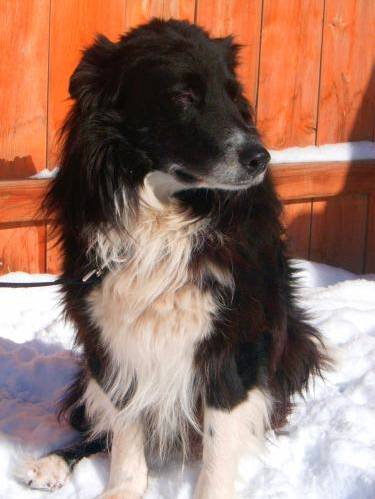

In [10]:
import random
from PIL import Image
import glob
from pathlib import Path

# Set seed
random.seed(42) 

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img


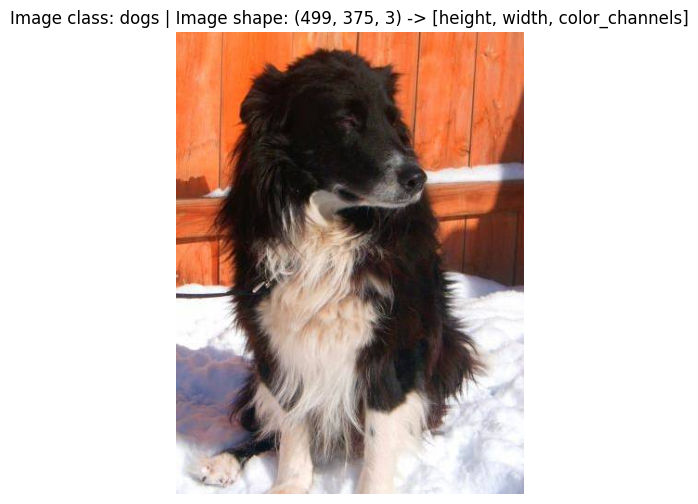

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE 
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

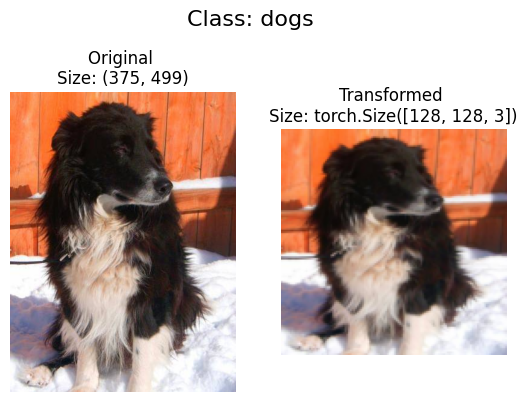

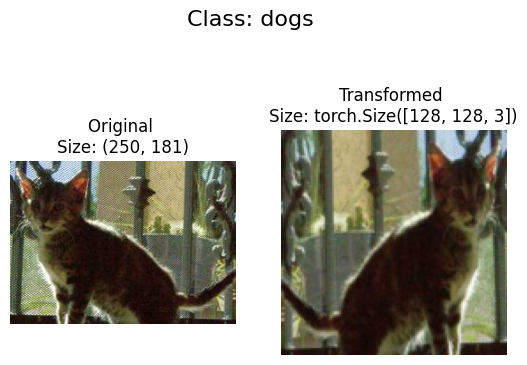

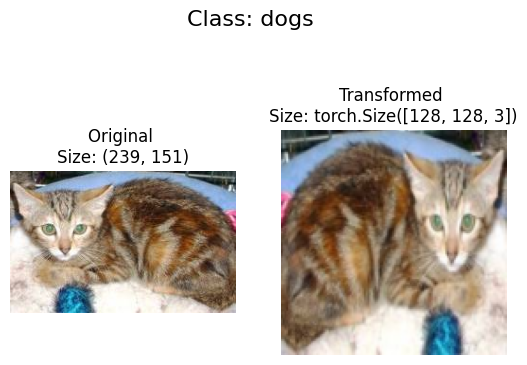

In [16]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [18]:
from torchvision import datasets

# Creating training set
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, 
                                  target_transform=None) 
#Creating test set
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8005
    Root location: C:/Users/hmari/Desktop/IVI/PetImages/training_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2023
    Root location: C:/Users/hmari/Desktop/IVI/PetImages/test_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [19]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


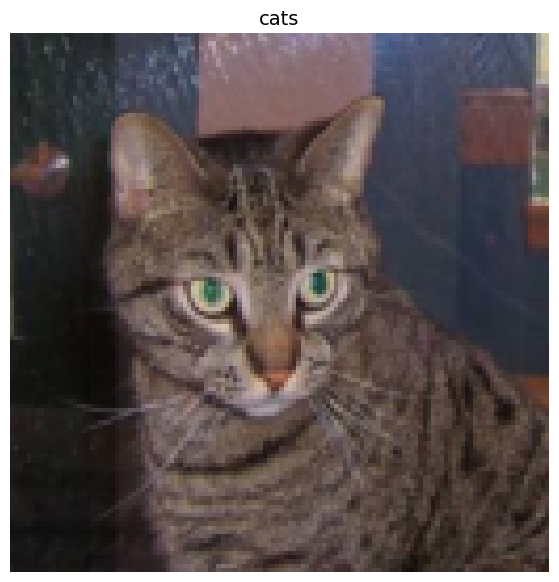

In [20]:
img, label = train_data[0][0], train_data[0][1]
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [21]:
from torch.utils.data import DataLoader

# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = os.cpu_count()

# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x194a7d12510>,
 <torch.utils.data.dataloader.DataLoader at 0x194a7ac6e10>)

In [23]:
img, label = next(iter(train_dataloader))

# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])